660710693 กาญจนาพร เขื่อน
660710717 นฤมล เวฬุวิริยกุล





In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv('/content/cafethai_prices.csv', parse_dates=['date'], date_format='%d/%m/%Y')
display(df.head())

,date,time,cash_type,coffee_name,money
0,2023-03-01,08:04:19,card,Latte,75
1,2023-03-01,08:08:54,cash,Americano with Milk,70
2,2023-03-01,08:09:03,card,Cappuccino,75
3,2023-03-01,08:10:26,cash,Cappuccino,75
4,2023-03-01,08:15:37,cash,Cappuccino,75


In [5]:
print(df["coffee_name"].unique())

['Latte' 'Americano with Milk' 'Cappuccino' 'Cortado' 'Americano'
 'Hot Chocolate' 'Cocoa' 'Espresso']


In [6]:
menu_list = df["coffee_name"].drop_duplicates().reset_index(drop=True)
print(menu_list)

0                  Latte
1    Americano with Milk
2             Cappuccino
3                Cortado
4              Americano
5          Hot Chocolate
6                  Cocoa
7               Espresso
Name: coffee_name, dtype: object


In [7]:
df.set_index('date', inplace=True)

df.head()

,time,cash_type,coffee_name,money
date,,,,
2023-03-01,08:04:19,card,Latte,75
2023-03-01,08:08:54,cash,Americano with Milk,70
2023-03-01,08:09:03,card,Cappuccino,75
2023-03-01,08:10:26,cash,Cappuccino,75
2023-03-01,08:15:37,cash,Cappuccino,75


In [8]:
daily_sales = df.groupby(['date', 'coffee_name'])['money'].sum().reset_index()
daily_sales.head()

,date,coffee_name,money
0,2023-03-01,Americano,1235
1,2023-03-01,Americano with Milk,1890
2,2023-03-01,Cappuccino,1800
3,2023-03-01,Cocoa,350
4,2023-03-01,Cortado,980


In [9]:
daily_item_counts = df.groupby(['date', 'coffee_name']).size().reset_index(name='count')
daily_item_counts.head()

,date,coffee_name,count
0,2023-03-01,Americano,19
1,2023-03-01,Americano with Milk,27
2,2023-03-01,Cappuccino,24
3,2023-03-01,Cocoa,7
4,2023-03-01,Cortado,14


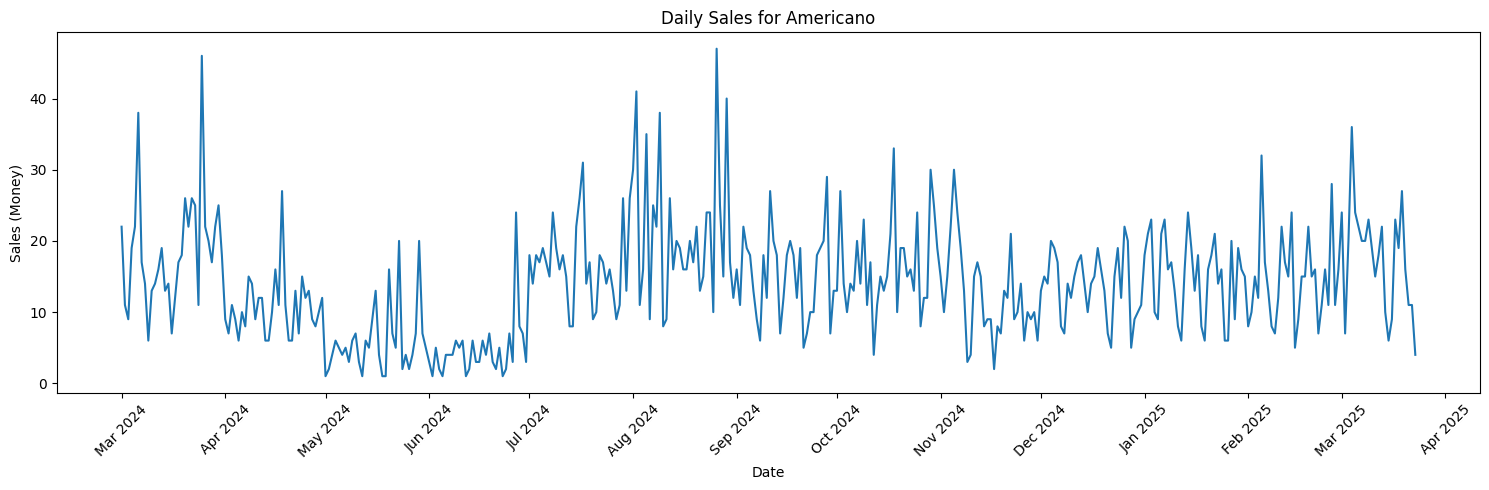

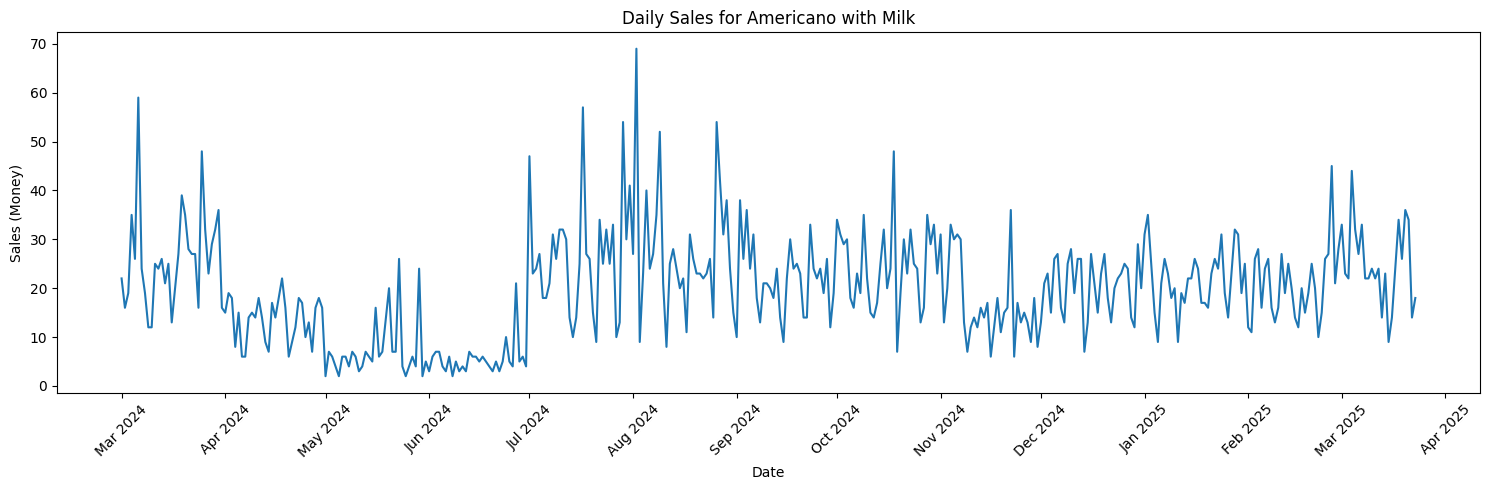

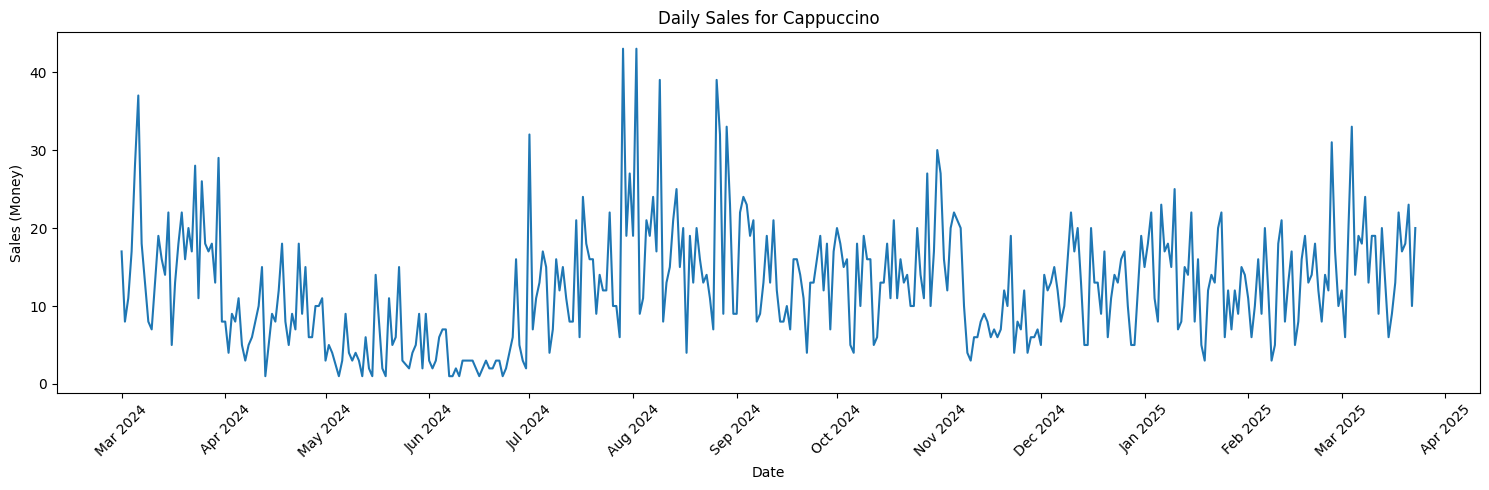

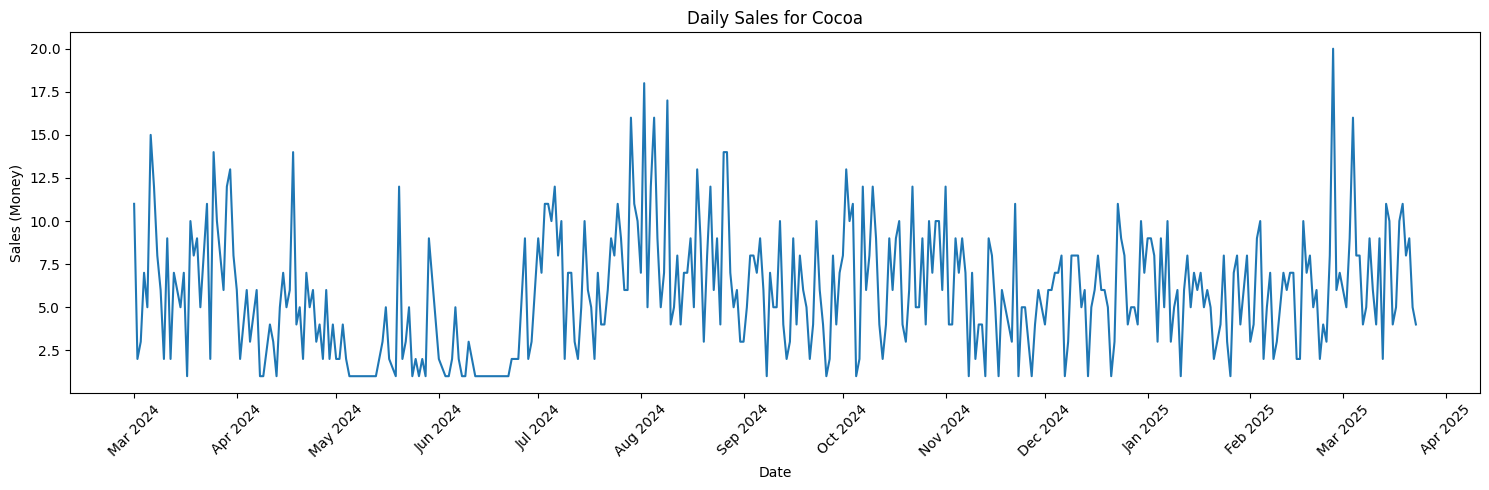

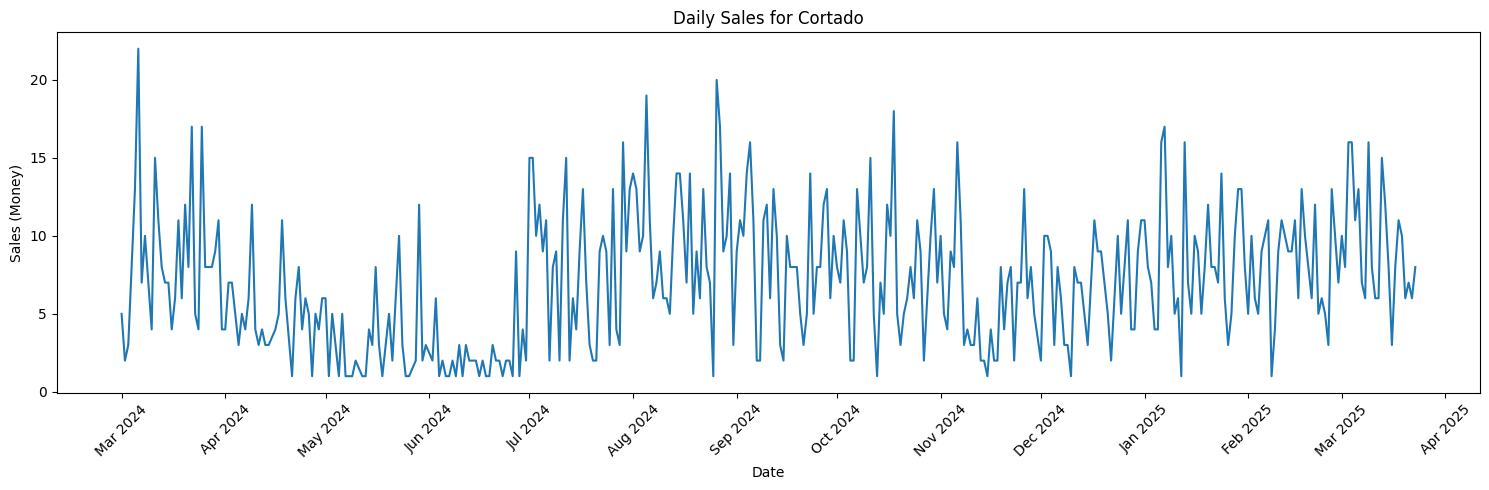

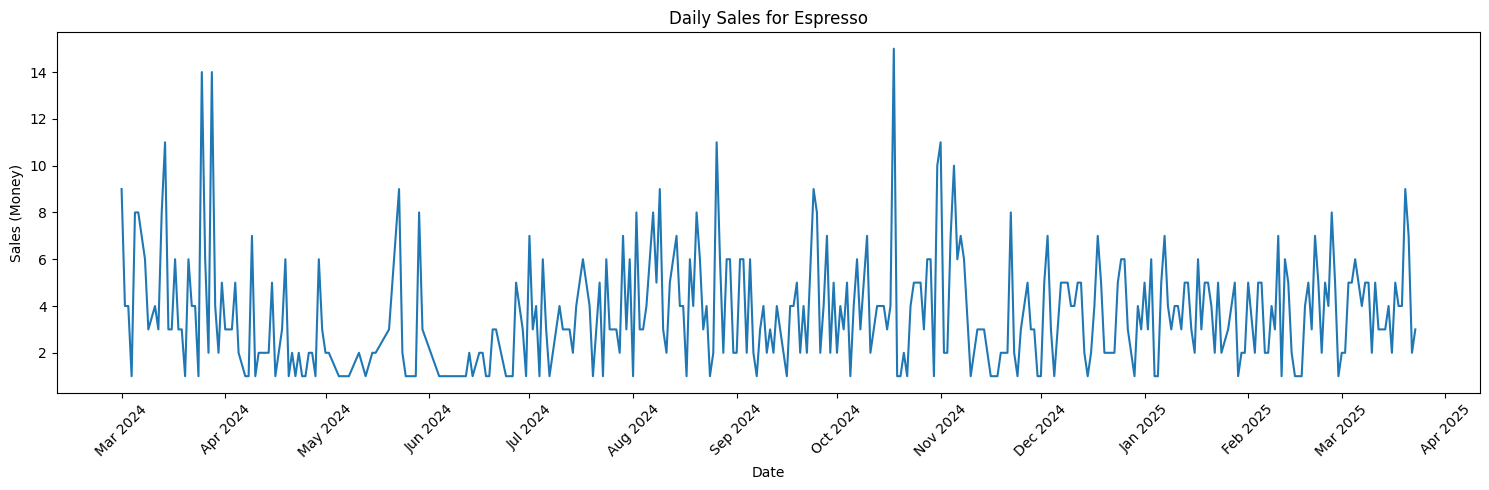

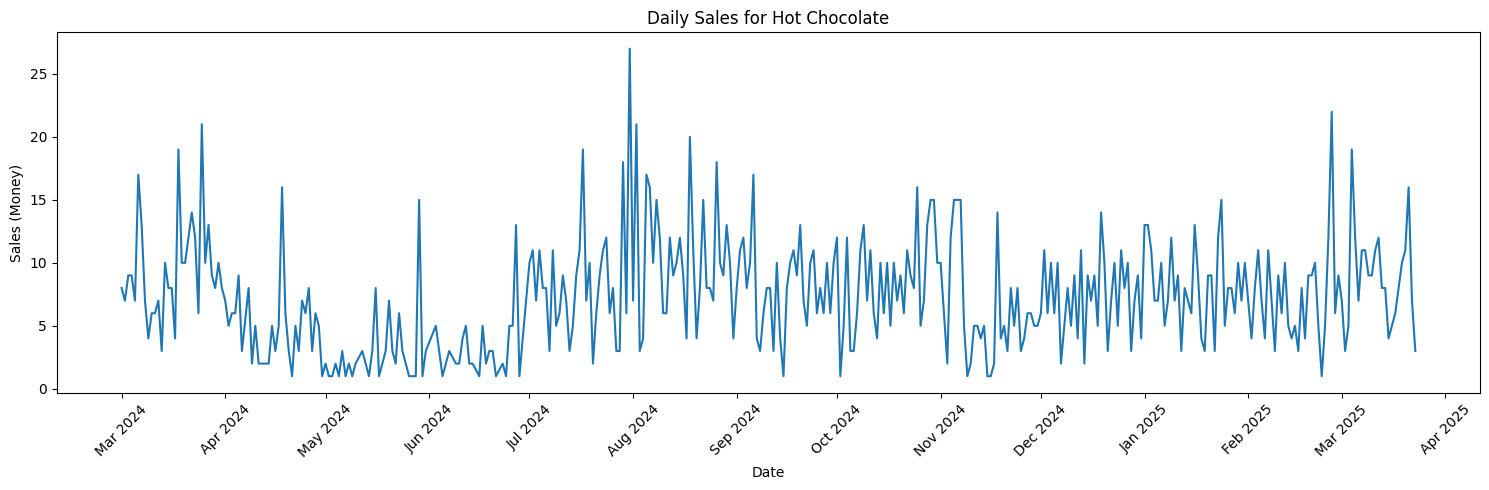

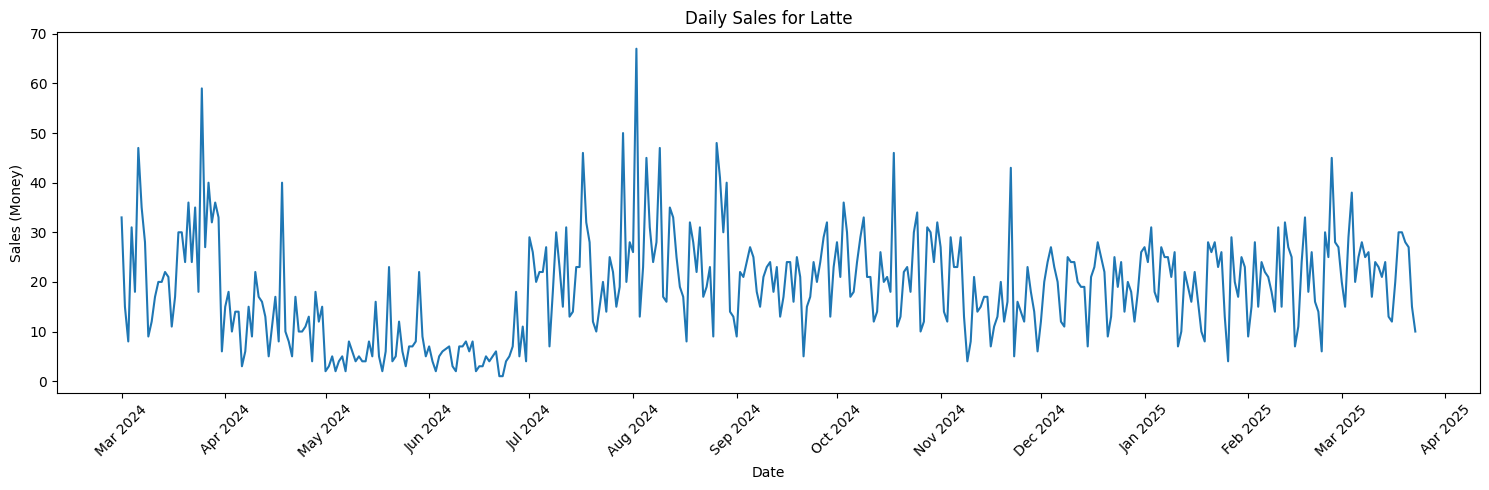

In [10]:
# รวมเป็นจำนวนแก้วต่อวันต่อกาแฟ (count)
daily_sales = df.groupby(['date', 'coffee_name']).size().reset_index(name='cups')

# Plot daily sales for each coffee item
for coffee_name in daily_sales['coffee_name'].unique():
    coffee_sales = daily_sales[daily_sales['coffee_name'] == coffee_name].copy() # Create a copy to avoid SettingWithCopyWarning
    # Ensure date is datetime, convert if needed with the correct format
    if not pd.api.types.is_datetime64_any_dtype(coffee_sales['date']):
         coffee_sales['date'] = pd.to_datetime(coffee_sales['date'], format='%d/%m/%Y', errors='coerce')

    coffee_sales.dropna(subset=['date'], inplace=True) # Remove rows with invalid dates

    # Filter data by date range
    # Update start and end dates if needed based on the correct format
    start_date = '2024-03-01' # Assuming the user wants to start from March 1, 2024
    end_date = '2025-03-23'
    coffee_sales = coffee_sales[(coffee_sales['date'] >= start_date) & (coffee_sales['date'] <= end_date)]

    coffee_sales.set_index('date', inplace=True) # Set date as index for easier plotting


    plt.figure(figsize=(15, 5))
    plt.plot(coffee_sales.index, coffee_sales['cups'])
    plt.title(f'Daily Sales for {coffee_name}')
    plt.xlabel('Date')
    plt.ylabel('Sales (Money)')

    # Format x-axis to show month and year
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b %Y'))
    plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())


    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [19]:
def create_sales_features(df):
    # Ensure date is datetime and set as index
    # Check if date is already datetime, if not convert with the correct format
    if not pd.api.types.is_datetime64_any_dtype(df['date']):
        df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y', errors='coerce')

    df.set_index('date', inplace=True)

    # Create features from date
    df['dayofweek'] = df.index.dayofweek # 0 = Monday, 6 = Sunday
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['dayofyear'] = df.index.dayofyear
    df['year'] = df.index.year # Add year feature

    # Sort by date before creating lag features
    df.sort_index(inplace=True)

    # Create Lag Features (previous sales)
    # We'll use data from 7 days and 14 days ago to help predict
    df['lag_7'] = df['count'].shift(7)
    df['lag_14'] = df['count'].shift(14)

    # Create Rolling Mean
    df['rolling_mean_7'] = df['count'].shift(1).rolling(window=7).mean()

    # Reset index to make date a column again
    df.reset_index(inplace=True)

    return df


daily_item_counts_features = create_sales_features(daily_item_counts.copy())


# Drop rows with NaN values created by lag features
daily_item_counts_features.dropna(inplace=True)

display(daily_item_counts_features.head())

,date,coffee_name,count,dayofweek,quarter,month,dayofyear,year,lag_7,lag_14,rolling_mean_7
14,2023-03-02,Hot Chocolate,7,3,1,3,61,2023,24.0,19.0,15.857143
15,2023-03-02,Latte,31,3,1,3,61,2023,19.0,27.0,13.428571
16,2023-03-03,Americano,19,4,1,3,62,2023,26.0,24.0,15.142857
17,2023-03-03,Americano with Milk,27,4,1,3,62,2023,18.0,7.0,14.142857
18,2023-03-03,Cappuccino,16,4,1,3,62,2023,8.0,14.0,15.428571


In [20]:
# Convert 'date' column to datetime objects
# Ensure 'date' is a column first if it was set as index
if df.index.name == 'date':
    df.reset_index(inplace=True)

df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y', errors='coerce')

# Display the data types to confirm the conversion
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68359 entries, 0 to 68358
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         68359 non-null  datetime64[ns]
 1   time         68359 non-null  object        
 2   cash_type    68359 non-null  object        
 3   coffee_name  68359 non-null  object        
 4   money        68359 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 2.6+ MB


None

In [23]:
FEATURES = ['dayofweek', 'quarter', 'month', 'dayofyear', 'lag_7', 'lag_14', 'rolling_mean_7']
TARGET = 'count'

In [24]:
X = daily_item_counts_features[FEATURES]
y = daily_item_counts_features[TARGET]

In [25]:
# Determine the split date
split_date = '2025-03-31'

# Ensure the 'date' column is in datetime format for comparison
daily_total_sales_features['date'] = pd.to_datetime(daily_total_sales_features['date'])

# Split data into training and testing sets based on date
train_data = daily_total_sales_features[daily_total_sales_features['date'] < split_date]
test_data = daily_total_sales_features[daily_total_sales_features['date'] >= split_date]

X_train = train_data[FEATURES]
y_train = train_data[TARGET]
X_test = test_data[FEATURES]
y_test = test_data[TARGET]


print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (5915, 7)
Shape of y_train: (5915,)
Shape of X_test: (242, 7)
Shape of y_test: (242,)


In [26]:
# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [27]:
# XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=100,
                             learning_rate=0.05, # ค่อยๆ เรียนรู้ช้าๆ
                             early_stopping_rounds=10, # ถ้าผลไม่ดีขึ้น 10 รอบให้หยุด
                             random_state=42)

In [28]:
# XGBoost ต้องมี evaluation set เพื่อใช้ early stopping
xgb_model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
              verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [29]:
rf_pred = rf_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)

In [30]:
rf_mae = mean_absolute_error(y_test, rf_pred)
xgb_mae = mean_absolute_error(y_test, xgb_pred)

In [31]:
print(f"\nความคลาดเคลื่อนเฉลี่ยของ Random Forest: {rf_mae:.2f} จากทั้งหมด {len(y_test)} จุดข้อมูล")
print(f"ความคลาดเคลื่อนเฉลี่ยของ XGBoost: {xgb_mae:.2f} จากทั้งหมด {len(y_test)} จุดข้อมูล")
print(f"ยอดขายรวมใน Test Set: {y_test.sum():.2f} บาท")


ความคลาดเคลื่อนเฉลี่ยของ Random Forest: 3.88 จากทั้งหมด 242 จุดข้อมูล
ความคลาดเคลื่อนเฉลี่ยของ XGBoost: 3.76 จากทั้งหมด 242 จุดข้อมูล
ยอดขายรวมใน Test Set: 2032.00 บาท


In [32]:
results = pd.DataFrame({
    'Actual': y_test,
    'Random Forest': rf_pred,
    'XGBoost': xgb_pred
})

# Set the index of the results DataFrame to the dates from the test set
results.index = test_data['date']

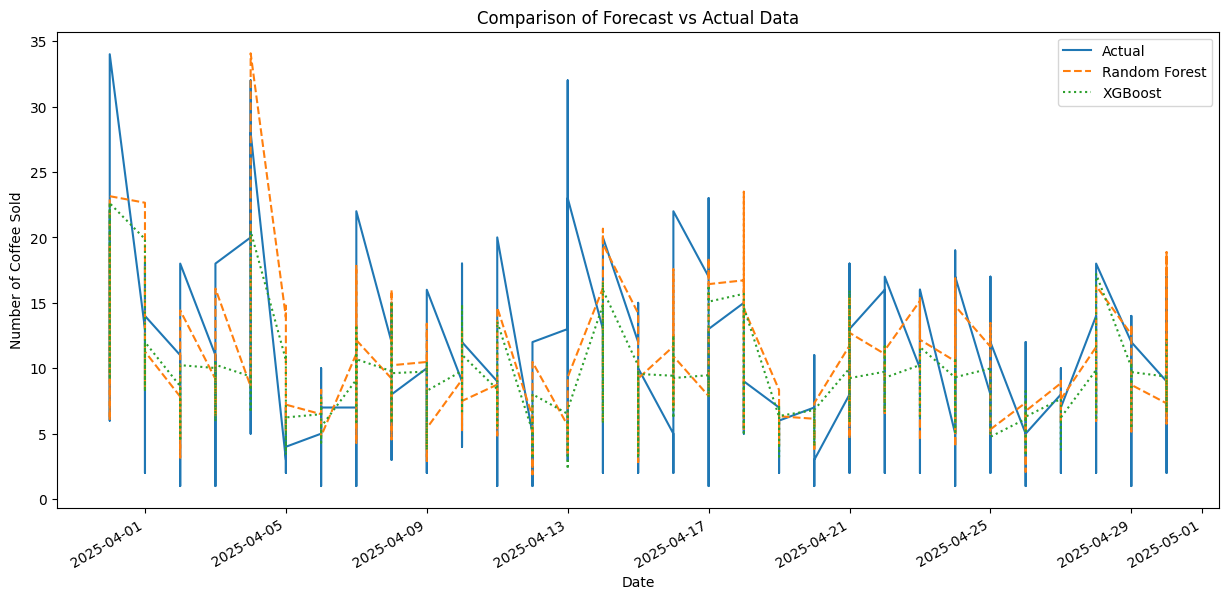

In [33]:
results.plot(figsize=(15, 7), style=['-', '--', ':'],
             title='Comparison of Forecast vs Actual Data')
plt.ylabel('Number of Coffee Sold')
plt.xlabel('Date')
plt.legend()
plt.show()

In [34]:
def plot_feature_importance(model, features, model_name):
    # สร้าง DataFrame ของ feature importance
    fi = pd.DataFrame(data=model.feature_importances_,
                      index=features,
                      columns=['importance'])
    fi_sorted = fi.sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=fi_sorted.index, y=fi_sorted['importance'])
    plt.title(f'Feature Importance of the {model_name} Model') # Changed title to English
    plt.xticks(rotation=45)
    plt.xlabel('Features') # Added x-axis label
    plt.show()

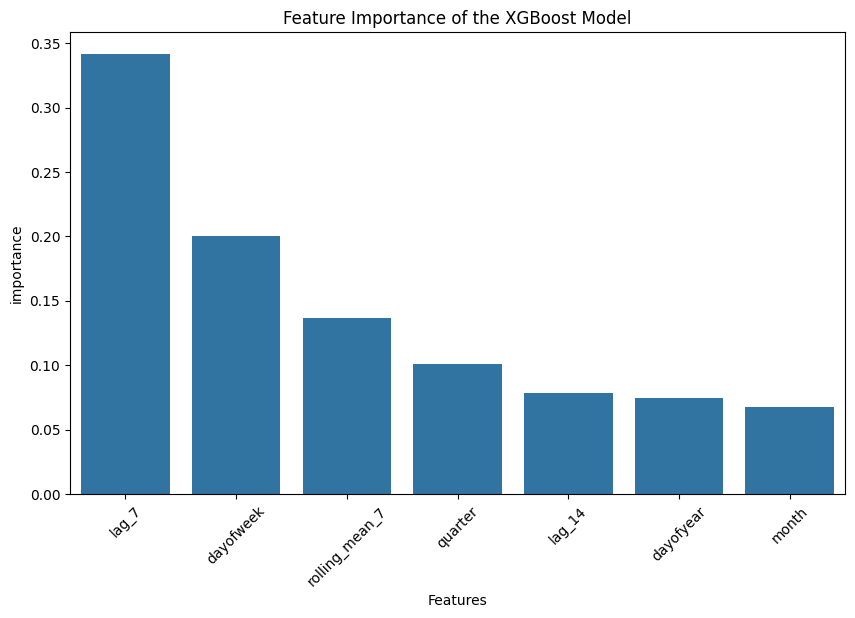

In [35]:
plot_feature_importance(xgb_model, FEATURES, 'XGBoost')

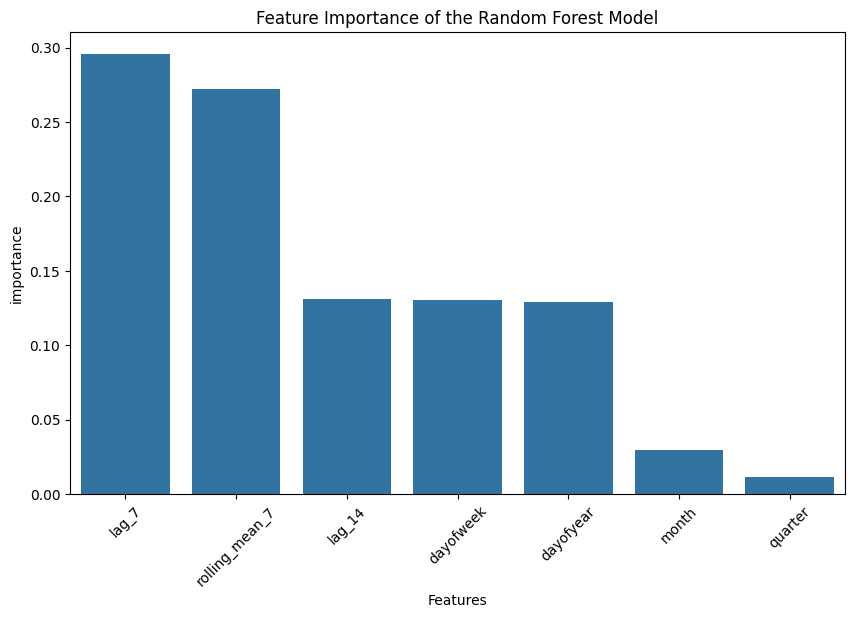

In [36]:
plot_feature_importance(rf_model, FEATURES, 'Random Forest')

In [37]:
!pip install prophet

In [38]:
from prophet import Prophet

In [39]:
# Prepare data for Prophet: requires 'ds' (datetime) and 'y' (target) columns
# Use the already split train_data and test_data DataFrames

# Add print statements to check columns
print("Columns in train_data:", train_data.columns)
print("Columns in test_data:", test_data.columns)

Columns in train_data: Index(['date', 'coffee_name', 'count', 'dayofweek', 'quarter', 'month',
       'dayofyear', 'year', 'lag_7', 'lag_14', 'rolling_mean_7'],
      dtype='object')
Columns in test_data: Index(['date', 'coffee_name', 'count', 'dayofweek', 'quarter', 'month',
       'dayofyear', 'year', 'lag_7', 'lag_14', 'rolling_mean_7'],
      dtype='object')


In [41]:
prophet_train = train_data[['date', 'count']].rename(columns={'date': 'ds', 'count': 'y'})
prophet_test = test_data[['date', 'count']].rename(columns={'date': 'ds', 'count': 'y'})

# Prophet requires a continuous time series without missing dates.
# It's generally recommended to ensure the data has a daily frequency and fill missing dates if necessary.
# For simplicity now, we'll use the data as is, but note this for potential issues.
# If there are missing dates, Prophet can handle them to some extent but performance might be affected.

In [42]:
# Initialize and fit the Prophet model
model = Prophet(weekly_seasonality=True,yearly_seasonality=True)
model.fit(prophet_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3bxeupa/irjosj7d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmph3bxeupa/wdfmaem9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89516', 'data', 'file=/tmp/tmph3bxeupa/irjosj7d.json', 'init=/tmp/tmph3bxeupa/wdfmaem9.json', 'output', 'file=/tmp/tmph3bxeupa/prophet_modeljarrledm/prophet_model-20250921203634.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:36:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:36:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [43]:
# Display the index (dates) of the RF/XGBoost test set
display(y_test.index)

Index([5929, 5930, 5931, 5932, 5933, 5934, 5935, 5936, 5937, 5938,
       ...
       6161, 6162, 6163, 6164, 6165, 6166, 6167, 6168, 6169, 6170],
      dtype='int64', length=242)

In [44]:
# Create a future dataframe for predictions
# We need to predict for the dates in the test set
future = model.make_future_dataframe(periods=len(prophet_test))

In [45]:
# Make predictions
forecast = model.predict(future)

In [46]:
# Display the forecast
display(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

,ds,yhat,yhat_lower,yhat_upper
0,2023-03-02,14.577592,4.740400,24.516457
1,2023-03-03,14.048237,3.902954,24.273625
2,2023-03-04,8.795555,-1.989007,18.354073
3,2023-03-05,8.995534,-0.482182,19.210562
4,2023-03-06,14.856752,4.327295,25.461485


In [47]:
# Evaluate the Prophet model
# Merge actual values with forecast
prophet_results = forecast.set_index('ds')[['yhat']].join(prophet_test.set_index('ds')[['y']])
prophet_results.dropna(inplace=True) # Drop rows where there are no actual values (if future was longer than test)

In [48]:
# Calculate MAE
prophet_mae = mean_absolute_error(prophet_results['y'], prophet_results['yhat'])

print(f"ความคลาดเคลื่อนเฉลี่ยของ Prophet: {prophet_mae:.2f} จากทั้งหมด {len(prophet_results)} จุดข้อมูล")
print(f"ยอดขายรวมใน Test Set (สำหรับ Prophet): {prophet_results['y'].sum():.2f} บาท")

ความคลาดเคลื่อนเฉลี่ยของ Prophet: 4.71 จากทั้งหมด 242 จุดข้อมูล
ยอดขายรวมใน Test Set (สำหรับ Prophet): 2032.00 บาท


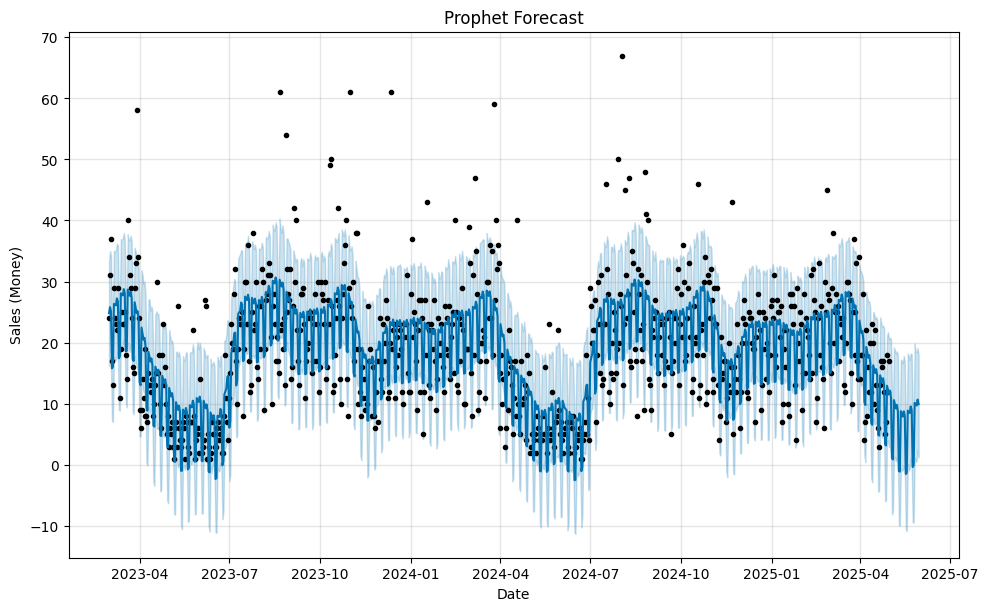

In [50]:
fig1 = model.plot(forecast)
plt.title('Prophet Forecast')
plt.xlabel('Date')
plt.ylabel('Sales (Money)')
plt.show()

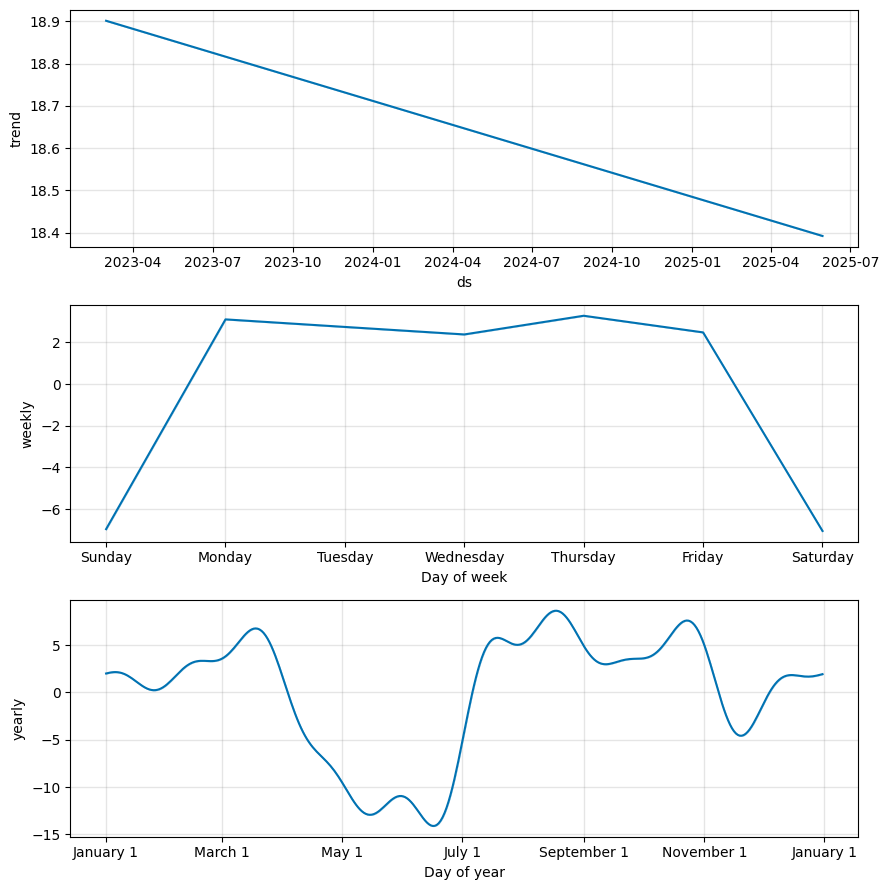

In [51]:
fig2 = model.plot_components(forecast)
plt.show()

In [52]:
pip install git+https://github.com/amazon-science/chronos-forecasting.git

  Cloning https://github.com/amazon-science/chronos-forecasting.git to /tmp/pip-req-build-uic4xu29
  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git /tmp/pip-req-build-uic4xu29
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit fcd09fe8b6bf57643bde7847bf42a6719b7ee205
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for chronos-forecasting: filename=chronos_forecasting-1.5.3-py3-none-any.whl size=29457 sha256=1ed17963a7cb042bbb2bbd927e0f5c26133b09dc77300086832dedd8cf911cd2
  Stored in directory: /tmp/pip-ephem-wheel-cache-kinsct3l/wheels/b9/a6/b5/75fca7306751a3bc92a63680f861f44a42a8776f6423cf0188
Successfully built chronos-forecasting


In [53]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from chronos import ChronosPipeline

In [54]:
pipeline = ChronosPipeline.from_pretrained(
  "amazon/chronos-t5-small",
  device_map="cuda",
  dtype=torch.bfloat16,
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/185M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

In [57]:
# Prepare the data for Chronos
# Chronos expects a torch tensor as input. We'll use the 'total_sales' column
# Filter data before the split date
split_date = pd.to_datetime('2025-03-01')
historical_sales_before_split = daily_item_counts[daily_item_counts['date'] < split_date].copy()


# Convert the 'count' column from the filtered data to a torch tensor
context = torch.tensor(historical_sales_before_split['count'].values)

# Define the prediction length (e.g., 60 days for one month forecast)
prediction_length = 60

# Make a forecast using the Chronos pipeline
forecast = pipeline.predict(context, prediction_length)

# The forecast is a distribution. We can get the median prediction.
# The forecast tensor will have shape (num_samples, prediction_length)
# We take the median along the sample dimension (dim=0)
median_prediction = forecast[0].median(dim=0).values

# Display the median prediction
print(f"Chronos Median Forecast for the next {prediction_length} days:")
display(median_prediction)

Chronos Median Forecast for the next 60 days:


tensor([11.9743, 15.0334,  9.9640,  6.0309,  6.0309,  4.9820,  6.9923, 11.0129,
        13.0232, 13.9846,  8.4782,  4.9820,  6.4679,  6.9923, 11.0129, 16.9563,
        15.9949, 13.9846, 11.0129,  6.9923,  6.0309,  6.0309, 13.9846, 15.9949,
        16.9563, 20.0155, 18.9666, 11.0129, 11.0129, 20.0155, 20.9769, 18.0052,
        20.0155, 15.0334, 13.0232, 11.9743,  9.0026, 11.0129, 10.4885, 15.9949,
        15.9949,  8.0411, 13.0232,  9.0026,  6.0309,  9.0026, 13.0232, 15.9949,
        15.0334, 12.9358,  6.9923,  4.9820,  8.0411,  8.0411, 11.9743, 11.9743,
         9.9640, 13.9846,  6.9923,  8.0411])

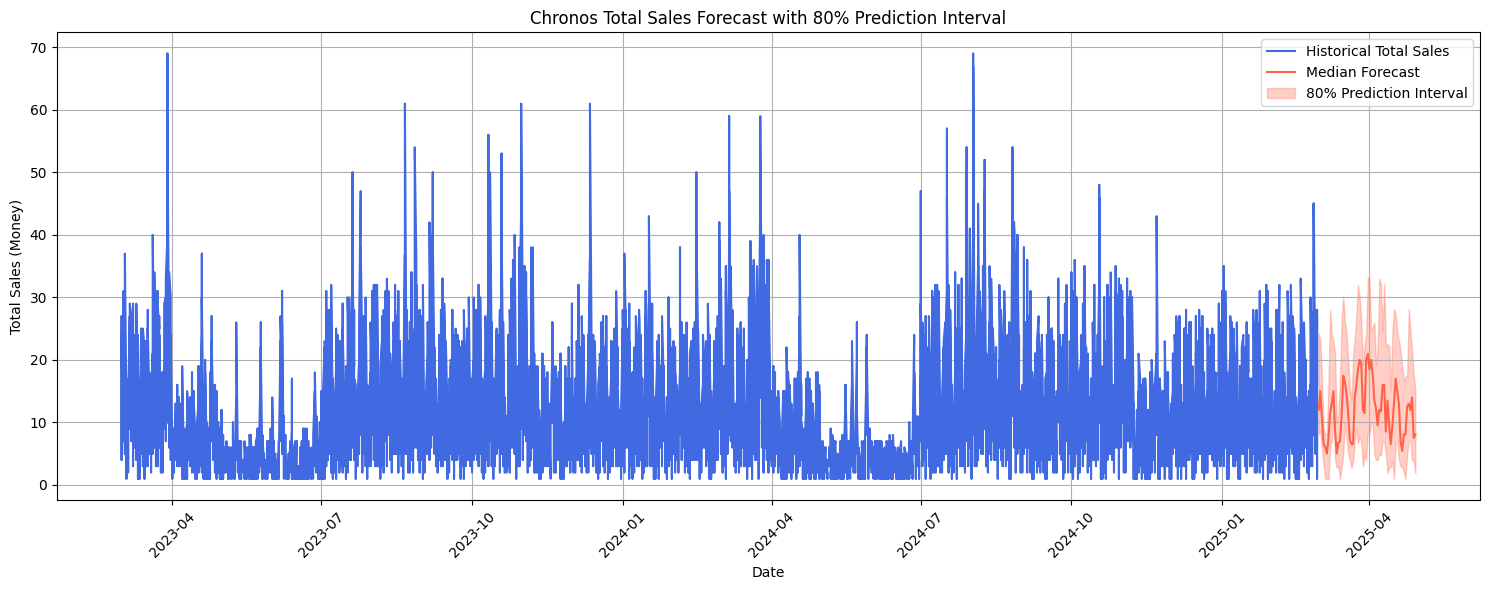

In [59]:
# Visualize the Chronos forecast with prediction interval
plt.figure(figsize=(15, 6))

# Plot historical data (daily_total_sales before split_date)
plt.plot(historical_sales_before_split['date'], historical_sales_before_split['count'], color="royalblue", label="Historical Total Sales")

# Create dates for the forecast period
# The forecast starts immediately after the last date in the historical_sales_before_split
last_date_historical = historical_sales_before_split['date'].iloc[-1]
forecast_dates = pd.date_range(start=last_date_historical + pd.Timedelta(days=1), periods=prediction_length, freq='D')

# Calculate quantiles for the prediction interval
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

# Plot the median forecast
plt.plot(forecast_dates, median, color="tomato", label="Median Forecast")

# Plot the 80% prediction interval
plt.fill_between(forecast_dates, low, high, color="tomato", alpha=0.3, label="80% Prediction Interval")


plt.title('Chronos Total Sales Forecast with 80% Prediction Interval')
plt.xlabel('Date')
plt.ylabel('Total Sales (cups)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [60]:
forecast[0][:][0]

tensor([26.0463,  9.0026, 11.0129,  4.9820,  6.9923,  0.9614,  4.0206,  6.9923,
        13.0232, 20.9769, 13.9846,  0.9614,  6.9923,  0.9614,  4.0206,  9.0026,
        15.0334, 24.0360, 29.9795,  8.4782, 11.9743,  4.0206,  6.0309, 15.9949,
        13.9846, 20.0155, 24.9975, 13.9846,  6.9923,  2.0103,  0.9614,  8.0411,
        13.9846,  4.9820, 25.9589, 13.9846,  6.0309, 13.9846,  2.9717, 11.0129,
        22.9872,  6.4679, 27.0952, 24.0360, 13.9846, 15.9949,  4.9820,  9.0026,
        24.0360, 15.0334, 18.9666, 18.9666,  4.9820,  0.9614,  8.0411,  6.9923,
         9.0026, 15.9949,  6.9923,  6.9923])

In [61]:
median_forecast = np.median(forecast[0], axis=0)

print("ค่ามัธยฐานของผลการพยากรณ์ 12 เดือนข้างหน้า")
print(median_forecast)

ค่ามัธยฐานของผลการพยากรณ์ 12 เดือนข้างหน้า
[11.974318  15.033449  10.488453   6.5115814  6.0308604  4.9820156
  7.5167246 11.493597  13.023163  14.989748   8.740377   4.9820156
  6.730091   6.9923024 11.012876  17.480755  16.47561   14.509027
 11.493597   7.2545137  6.5115814  6.5115814 13.984604  15.994891
 18.485897  20.015465  19.491043  12.018019  11.493597  20.015465
 20.976906  18.485899  20.015465  17.524456  13.503883  12.236528
  9.483311  12.018019  11.755808  15.994891  15.994891   8.521868
 13.503883   9.745522   6.5115814  9.483311  13.023163  17.000034
 15.033449  12.979462   6.9923024  5.462736   8.041147   8.041147
 12.49874   12.979461  11.974318  13.984604   7.5167246  8.041147 ]
